<a href="https://colab.research.google.com/github/ngocchaupham/cancer_classification_ML-/blob/main/cancer_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tumor Classification: RNA-Seq Data Set
This data set originates from the UCI Machine Learning Repository. It is a subset of the RNA-Seq (HiSeq) PANCAN data set, featuring a random selection of gene expression profiles from patients with various tumor types: BRCA, KIRC, COAD, LUAD, and PRAD. The dataset includes 801 samples, each with 20,531 attributes.

Samples (instances) are organized in a row-wise format. The variables (attributes) for each sample represent RNA-Seq gene expression levels, as measured by the Illumina HiSeq platform.

Each attribute is assigned a placeholder name (gene_XX).


# 1. Read in data and load modules

In [1]:
!python --version

Python 3.10.12


In [2]:
!pip install umap-learn

In [120]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/master BSG/Gene expression cancer RNA-Seq_data/data.csv')
labels = pd.read_csv('/content/drive/MyDrive/master BSG/Gene expression cancer RNA-Seq_data/labels.csv')
data.head()


,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [5]:
labels.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


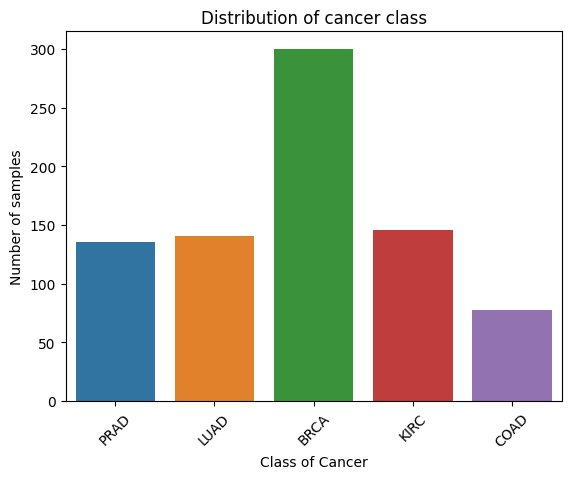

In [6]:
# Visualize the distribution of cancer classes
sns.countplot(x='Class', data=labels)
plt.title('Distribution of cancer class')
plt.xlabel('Class of Cancer')
plt.ylabel('Number of samples')
plt.xticks(rotation=45)
plt.show()

## Rename data frames, drop sample  names

In [30]:
Sample = data['Unnamed: 0']
X = data.drop(columns=['Unnamed: 0'])
Y = labels.Class
X.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


# 2. Data preprocessing


## Missing values

Examine the number of missing values (NA) in the dataframe. Missing data can lead to misleading results when analyzing the data or training a machine learning model.

In [8]:
nombre_total_na = data.isna().sum().sum()
print (nombre_total_na)

0


##Standardize data

In [61]:
# Initialize the StandardScaler
scaler = StandardScaler()
# Standardize the data (mean=0, std=1 for each characteristic)
data_standardized = scaler.fit_transform(X)
data_standardized.shape

(801, 20531)

# 3. Exploratory data analysis




## Summary Statistics

In [14]:
data.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133



## Principle component analysis


By using PCA(n_components=0.95), we reduce the complexity of the model, which can help avoid overfitting and reduce calculation time, while maintaining the majority of the information needed for classification or regression tasks.

In [62]:
#Feature Selection/Reduction
# Use PCA for dimensionality reduction, selecting top components that explain 95% variance
pca = PCA(n_components=0.95)
pca.fit(data_standardized)
reduced_data = pca.transform(data_standardized)
reduced_data.shape


(801, 530)

In [63]:
#Conversion numpy array to Dataframe
reduced_df = pd.DataFrame(reduced_data)
reduced_df['Class']=Y


In [64]:
reduced_df


,0,1,2,3,4,5,6,7,8,9,...,521,522,523,524,525,526,527,528,529,Class
0,-57.446987,95.410981,74.301543,-12.166781,7.981831,36.157573,-7.668542,19.951444,0.142216,3.035240,...,0.759257,0.069311,1.190453,-0.168946,-2.505679,0.499165,0.548185,-1.501202,-1.723332,PRAD
1,-16.919430,0.732470,-64.072900,-2.095308,-25.426430,27.784178,-16.132765,-17.031383,-22.023874,-27.923308,...,-3.873359,-1.716351,1.062815,-0.991165,-3.409572,-0.367755,0.855043,4.956671,0.068001,LUAD
2,-70.345218,-19.303327,20.488240,48.102893,24.437757,17.462510,20.706772,-47.626817,-28.647648,-12.784676,...,-0.705838,1.227124,-0.055377,0.406485,-0.413498,0.549849,1.063323,1.023867,-1.253420,PRAD
3,-49.161591,-9.227586,61.243770,37.805744,1.038889,23.240002,-4.801039,-21.554809,-15.375067,-12.881511,...,1.110073,2.633830,2.944072,1.410895,1.948946,3.714376,-2.717114,-0.832607,4.646922,PRAD
4,-18.132534,-51.327797,16.598116,-17.699201,26.389130,-1.551573,-6.266101,12.336677,-4.233837,28.804476,...,4.139632,-1.437741,2.040581,-0.174382,-0.132276,-1.026177,-3.027688,3.868726,-0.282360,BRCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,-12.417385,-42.321573,28.109566,-31.200320,38.814556,2.762444,-15.524261,10.618692,8.528240,27.573714,...,2.556504,-2.992007,-1.444393,2.188570,3.516752,2.385323,1.950367,-3.259282,-2.002624,BRCA
797,-29.415554,28.526281,-15.956631,-11.635178,-37.071404,-16.239422,-17.341039,-35.107458,-26.870257,31.147205,...,0.521074,0.037764,-0.105350,-1.097717,-1.536527,1.922901,-1.134164,-3.107927,-0.421312,LUAD
798,-4.133090,15.690014,-22.644453,-11.982424,-57.835783,-39.652668,47.718063,24.221214,22.709097,-32.888886,...,-0.743878,-0.738684,-0.227914,0.616901,0.240291,0.652893,-0.129178,-0.342774,0.451479,COAD
799,-30.814757,33.526423,70.565636,16.643656,-16.579983,-4.318571,20.482607,-9.552721,3.680009,-7.948784,...,-0.046790,0.031652,-0.477218,0.744758,0.949156,0.631748,1.527239,-0.112062,0.152790,PRAD


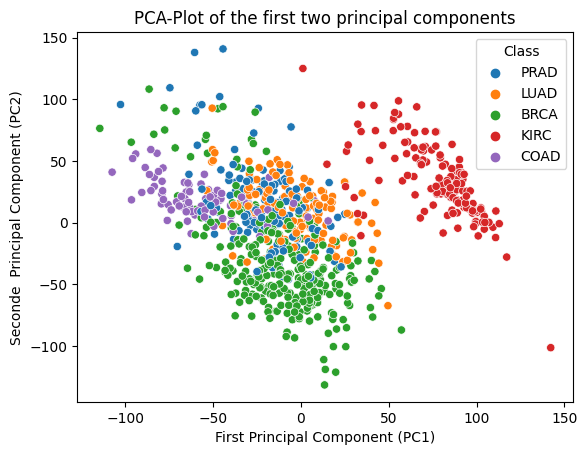

In [69]:
# Visualize PCA plot
sns.scatterplot(x=reduced_df.iloc[:, 0], y=reduced_df.iloc[:, 1], hue=reduced_df['Class'])
plt.title('PCA-Plot of the first two principal components')
plt.xlabel('First Principal Component (PC1)')
plt.ylabel('Seconde  Principal Component (PC2)')
plt.legend(title='Class')
plt.show()

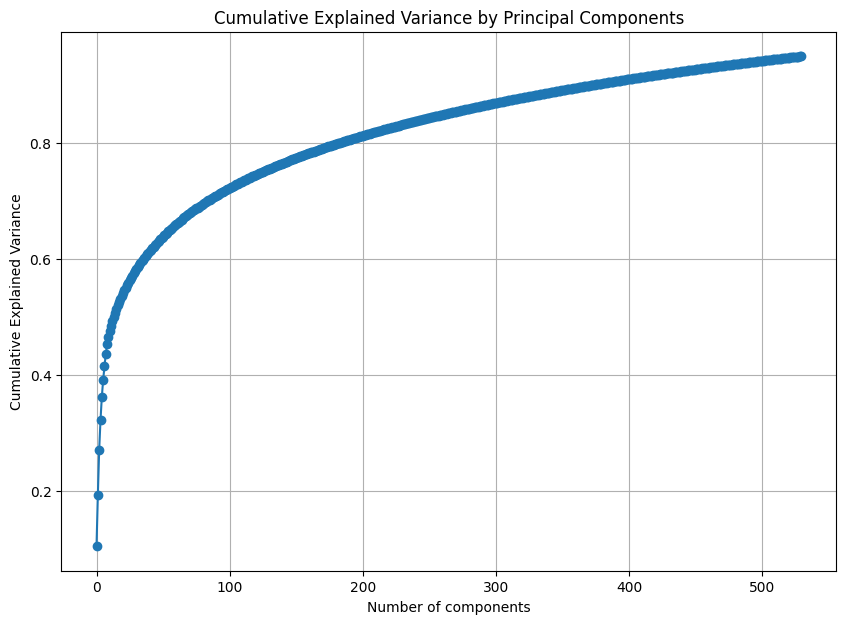

In [68]:
# Calculate the cumulative explained variance
variance_explained_cumulative = pca.explained_variance_ratio_.cumsum()
# Create a plot to visualize the cumulative explained variance
plt.figure(figsize=(10, 7))
plt.plot(variance_explained_cumulative, marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# 4. Machine learning on reduced data

##Split data into training and testing sets

In [77]:
X = reduced_df.drop('Class', axis=1)  # Features
y = reduced_df['Class']  # Target variable

In [78]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


##Random Forest Classifier

In [79]:
# Initialize the Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

In [80]:
# Train the model
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [81]:
# Predict on the test set
y_pred = rfc.predict(X_test)

In [82]:
# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
# Print the classification report for further detail
print(classification_report(y_test, y_pred))

Accuracy: 0.909433962264151
              precision    recall  f1-score   support

        BRCA       0.81      1.00      0.89       101
        COAD       1.00      0.76      0.86        29
        KIRC       1.00      0.87      0.93        47
        LUAD       1.00      0.77      0.87        43
        PRAD       1.00      0.98      0.99        45

    accuracy                           0.91       265
   macro avg       0.96      0.88      0.91       265
weighted avg       0.93      0.91      0.91       265



In [83]:
# Hyperparameter tuning (this is a simplified example with only a few parameters)
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, 30]  # Maximum depth of the trees
}
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model after grid search
best_rfc = grid_search.best_estimator_


In [85]:
# Evaluate the best model
best_pred = best_rfc.predict(X_test)
best_accuracy = accuracy_score(y_test, best_pred)
print(f'Best Accuracy after GridSearch: {best_accuracy}')
print(classification_report(y_test, best_pred))

Best Accuracy after GridSearch: 0.9018867924528302
              precision    recall  f1-score   support

        BRCA       0.82      0.99      0.90       101
        COAD       1.00      0.62      0.77        29
        KIRC       0.95      0.87      0.91        47
        LUAD       0.95      0.86      0.90        43
        PRAD       1.00      0.96      0.98        45

    accuracy                           0.90       265
   macro avg       0.94      0.86      0.89       265
weighted avg       0.91      0.90      0.90       265



## Support Vector Machine (SVM)

In [87]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_train)

# Apply transform to both the training set and the test set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [88]:
# Initialize SVM classifier
svm = SVC(kernel='linear')

In [89]:
#Train the model
svm.fit(X_train, y_train)

SVC(kernel='linear')

In [90]:
#Predict the response for the test dataset
y_pred = svm.predict(X_test)

In [91]:
#Evaluate accuracy
print(f"Accuracy: {accuracy_score(y_test,y_pred)}")

Accuracy: 0.7924528301886793


In [92]:
#Print classification report for performance metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        BRCA       0.70      0.97      0.81       101
        COAD       1.00      0.52      0.68        29
        KIRC       0.85      0.83      0.84        47
        LUAD       0.89      0.40      0.55        43
        PRAD       0.91      0.91      0.91        45

    accuracy                           0.79       265
   macro avg       0.87      0.72      0.76       265
weighted avg       0.83      0.79      0.78       265



In [93]:
#Hyperparameter Tuning using Grid Search
#Define a set of parameters to test
param_grid = {
    'C':[0.1, 1, 10], #Regularization parameter
    'gamma': ['scale',  'auto'], #Kernel coeficients for 'rbf', 'poly' and 'sigmoid'
    'kernel': ['linear', 'rbf'] # Specifies the kernel type to be used in the algorithm
}

In [94]:
# Initialize Grid Search with the SVM classifier, param_grid, and cross-validation
grid_search = GridSearchCV(svm, param_grid, refit=True, verbose=2, cv=3, n_jobs=-1)

# Fit the grid search model on the training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [95]:
# Get the best model after grid search
best_svm = grid_search.best_estimator_

# Predict with the best model
best_y_pred = best_svm.predict(X_test)


In [96]:
# Evaluate the best model
print(f"Best Model Accuracy: {accuracy_score(y_test, best_y_pred)}")
print(classification_report(y_test, best_y_pred))

Best Model Accuracy: 0.7924528301886793
              precision    recall  f1-score   support

        BRCA       0.70      0.97      0.81       101
        COAD       1.00      0.52      0.68        29
        KIRC       0.85      0.83      0.84        47
        LUAD       0.89      0.40      0.55        43
        PRAD       0.91      0.91      0.91        45

    accuracy                           0.79       265
   macro avg       0.87      0.72      0.76       265
weighted avg       0.83      0.79      0.78       265



##Logistic regression

In [99]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_train)

# Apply transform to both the training set and the test set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Initialize Logistic Regression Classifier
logreg = LogisticRegression(random_state=42, max_iter=10000)

In [100]:
# Train the model using the training sets
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [101]:
# Predict the response for the test dataset
y_pred = logreg.predict(X_test)

In [102]:
# Evaluate accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")

Accuracy: 0.8



In [103]:
# Print classification report for performance metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

        BRCA       0.70      1.00      0.82       101
        COAD       1.00      0.48      0.65        29
        KIRC       0.88      0.79      0.83        47
        LUAD       0.95      0.47      0.62        43
        PRAD       0.93      0.89      0.91        45

    accuracy                           0.80       265
   macro avg       0.89      0.72      0.77       265
weighted avg       0.84      0.80      0.79       265



In [104]:
# Hyperparameter Tuning using Grid Search
# Define a set of parameters to test
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Norm used in the penalization
    'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
}


In [105]:
# Initialize Grid Search with the Logistic Regression classifier, param_grid, and cross-validation
grid_search = GridSearchCV(logreg, param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)

# Fit the grid search model on the training data
grid_search.fit(X_train, y_train)

# Get the best model after grid search
best_logreg = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [106]:
# Predict with the best model
best_y_pred = best_logreg.predict(X_test)

# Evaluate the best model
print(f"Best Model Accuracy: {accuracy_score(y_test, best_y_pred)}\n")
print("Best Model Classification Report:\n", classification_report(y_test, best_y_pred))


Best Model Accuracy: 1.0

Best Model Classification Report:
               precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00       101
        COAD       1.00      1.00      1.00        29
        KIRC       1.00      1.00      1.00        47
        LUAD       1.00      1.00      1.00        43
        PRAD       1.00      1.00      1.00        45

    accuracy                           1.00       265
   macro avg       1.00      1.00      1.00       265
weighted avg       1.00      1.00      1.00       265



## Neuronal network

In [111]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y) # Convert string labels to integers
y_one_hot = to_categorical(y_encoded)  # One-hot encode the integer labels


In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.33, random_state=42)

In [116]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Neural network architecture
model = Sequential()
model.add(Dense(64, input_dim=X.shape[1], activation='relu'))  # First hidden layer with 64 neurons and ReLU activation
model.add(Dense(32, activation='relu'))  # Second hidden layer with 32 neurons and ReLU activation
model.add(Dense(y_one_hot.shape[1], activation='softmax'))  # Output layer with softmax activation


In [117]:
# Compile the model
model.compile(loss='categorical_crossentropy',  # Cross-entropy loss function
              optimizer='adam',                 # Optimization algorithm
              metrics=['accuracy'])             # Metric to track during training

In [118]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, validation_split=0.1)

61/61 [==============================] - 0s 5ms/step - loss: 2.6179e-05 - accuracy: 1.0000 - val_loss: 2.5521 - val_accuracy: 0.5370
Epoch 97/100
61/61 [==============================] - 0s 5ms/step - loss: 2.5172e-05 - accuracy: 1.0000 - val_loss: 2.5561 - val_accuracy: 0.5370
Epoch 98/100
61/61 [==============================] - 0s 5ms/step - loss: 2.4201e-05 - accuracy: 1.0000 - val_loss: 2.5608 - val_accuracy: 0.5370
Epoch 99/100
61/61 [==============================] - 0s 5ms/step - loss: 2.3276e-05 - accuracy: 1.0000 - val_loss: 2.5655 - val_accuracy: 0.5370
Epoch 100/100
61/61 [==============================] - 0s 5ms/step - loss: 2.2371e-05 - accuracy: 1.0000 - val_loss: 2.5697 - val_accuracy: 0.5370


In [119]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

Test loss: 2.2256879806518555
Test accuracy: 0.5207546949386597
